# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing as pp, visualization
import modules.data_generation as data_generation
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


2019-02-12 11:03:32 matplotlib-DEBUG: $HOME=/Users/annie
2019-02-12 11:03:32 matplotlib-DEBUG: matplotlib data path /Users/annie/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data
2019-02-12 11:03:32 matplotlib-DEBUG: loaded rc file /Users/annie/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
2019-02-12 11:03:32 matplotlib-DEBUG: matplotlib version 2.2.3
2019-02-12 11:03:32 matplotlib-DEBUG: interactive is False
2019-02-12 11:03:32 matplotlib-DEBUG: platform is darwin
2019-02-12 11:03:32 matplotlib-DEBUG: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'import

2019-02-12 11:03:32 matplotlib-DEBUG: CACHEDIR=/Users/annie/.matplotlib
2019-02-12 11:03:32 matplotlib.font_manager-DEBUG: Using fontManager instance from /Users/annie/.matplotlib/fontList.json
2019-02-12 11:03:32 matplotlib.backends-DEBUG: backend module://ipykernel.pylab.backend_inline version unknown
2019-02-12 11:03:32 matplotlib.backends-DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


/Users/annie/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [2]:
dg = DataGenerator(natoms=100, nclusters=4, natoms_per_cluster=[6,2,10,3], nframes_per_cluster=1000, 
                   noise_level=1e-2, 
                   displacement=0.1, test_model='non-linear')
#dg.generate_frames()
#dg.generate_clusters()
#feature_to_resids = dg.feature_to_resids()
dg.select_atoms_to_move()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = None
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2019-02-12 11:03:38 dataGen-INFO: Selecting atoms to be moved ...
2019-02-12 11:03:38 dataGen-INFO: Generating frames ...
2019-02-12 11:05:08 dataGenNb-INFO: Generated data of shape (4000, 4950) and 4 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [3]:
n_iterations, n_splits = 5, 2
filter_by_distance_cutoff = False 
feature_extractors = [
    fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(100,), training_max_iter=10000, 
                           activation="logistic", 
                           filter_by_distance_cutoff=filter_by_distance_cutoff), #, solver="sgd"),
    #fe.RbmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, n_components=8, 
    #                       filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    #fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
    #                       activation="relu",
    #                       n_nodes=dg.nfeatures, 
    #                       alpha=1.,
    #                       filter_by_distance_cutoff=filter_by_distance_cutoff),
    #fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits, 
    #                       filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_components=None,
                               filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                                                               filter_by_distance_cutoff=filter_by_distance_cutoff, one_vs_rest=True),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2019-02-12 11:05:36 mlp-DEBUG: Initializing MLP with the following parameters:                       n_splits 2, n_iterations 5, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       hidden_layer_sizes (100,), solver lbfgs, activation function logistic, randomize True, training_max_iter 10000
2019-02-12 11:05:36 PCA-DEBUG: Initializing PCA with the following parameters:                       n_splits 2, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_components None
2019-02-12 11:05:36 RF-DEBUG: Initializing RF with the following parameters:                       n_splits 2, n_iterations 5, scaling True, filter_by_distance_cutoff False, contact_cutoff 0.5,                       n_estimators 30, njobs -1
2019-02-12 11:05:36 dataGenNb-INFO: Done. using 3 feature extractors


In [ ]:
results = []
for extractor in feature_extractors:
    extractor.error_limit = 5
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2019-02-12 11:05:46 dataGenNb-INFO: Computing relevance for extractors MLP
2019-02-12 11:05:46 Extracting features-INFO: Performing feature extraction with MLP on data of shape (4000, 4950)
2019-02-12 11:05:48 mlp-DEBUG: Training MLP with 2000 samples and 4950 features ...
2019-02-12 11:05:50 mlp-DEBUG: Extracting feature importance using MLP ...
2019-02-12 11:05:51 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-02-12 11:05:51 mlp-DEBUG: Training MLP with 2000 samples and 4950 features ...
2019-02-12 11:05:53 mlp-DEBUG: Extracting feature importance using MLP ...
2019-02-12 11:05:54 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-02-12 11:05:54 mlp-DEBUG: Training MLP with 2000 samples and 4950 features ...
2019-02-12 11:05:56 mlp-DEBUG: Extracting feature importance using MLP ...
2019-02-12 11:05:56 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame bet

# Postprocess results to get average features

In [5]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids, 
                                     filter_results=False,
                                     predefined_relevant_residues=dg.moved_atoms, use_GMM_estimator=False)
    
    p.average().evaluate_performance()
    postprocessors.append([p])

logger.info("Done")


2019-02-12 11:00:06 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:07 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:07 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:07 projection-INFO: Scoring projections.
2019-02-12 11:00:09 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:09 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:09 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:09 projection-INFO: Scoring projections.
2019-02-12 11:00:11 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:11 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:11 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:11 projection-INFO: Scoring projections.
2019-02-12 11:00:13 dataGenNb-INFO: Done


# Evaluate results

## Find top ranked residues

In [6]:
logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            sorted(dg.moved_atoms), 
            dg.cluster_generation_method, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
def show_moved_atoms(dg, postprocessors):
    plt.figure(figsize=(6,6))
    yvalues = np.zeros(dg.moved_atoms.shape) + 1
    plt.scatter(dg.moved_atoms, yvalues, label="Actual")
    for pp in postprocessors:
        #Get most relevant atoms, not that they are not sorted
        label=pp.extractor.name
        moved_atoms = np.argpartition(pp.importance_per_residue, -dg.nclusters)[-dg.nclusters:]
        importance_moved_atoms = pp.importance_per_residue[moved_atoms]
        plt.scatter(moved_atoms, importance_moved_atoms, label=label, alpha=0.5)
        logger.info("Moved atoms for %s: %s", label, sorted(moved_atoms) )
    plt.legend()
    plt.grid()
    plt.show()
    
show_moved_atoms(dg, postprocessors)    

AttributeError: 'DataGenerator' object has no attribute 'cluster_generation_method'

## Visualize them

2019-02-12 11:00:20 utils-INFO: Rescaling feature importances ...
2019-02-12 11:00:20 matplotlib.font_manager-DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/annie/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


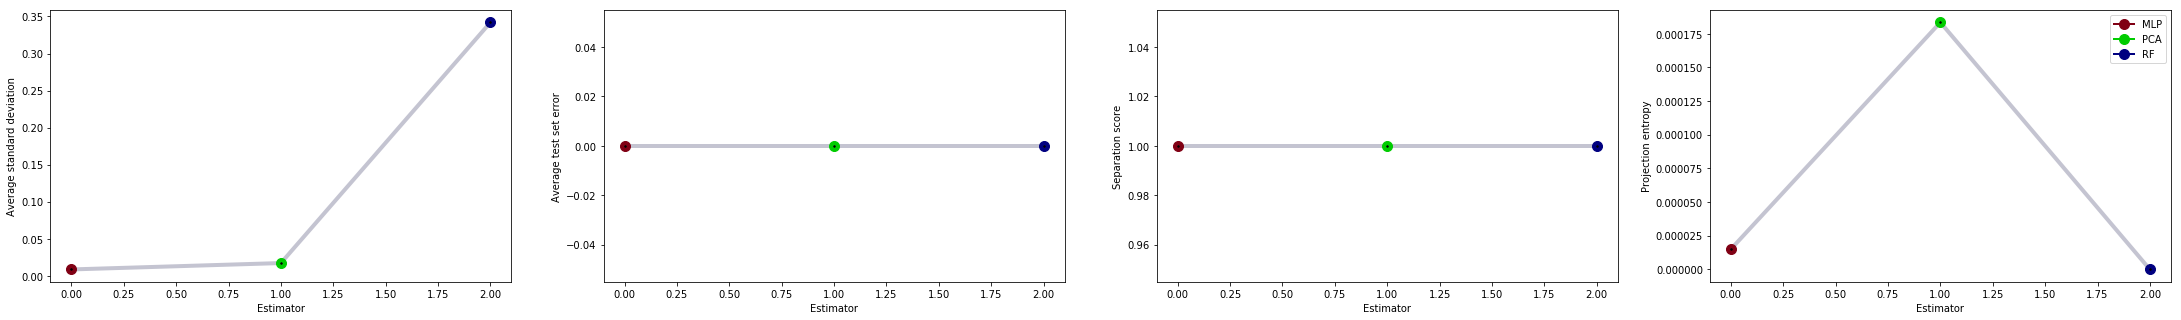

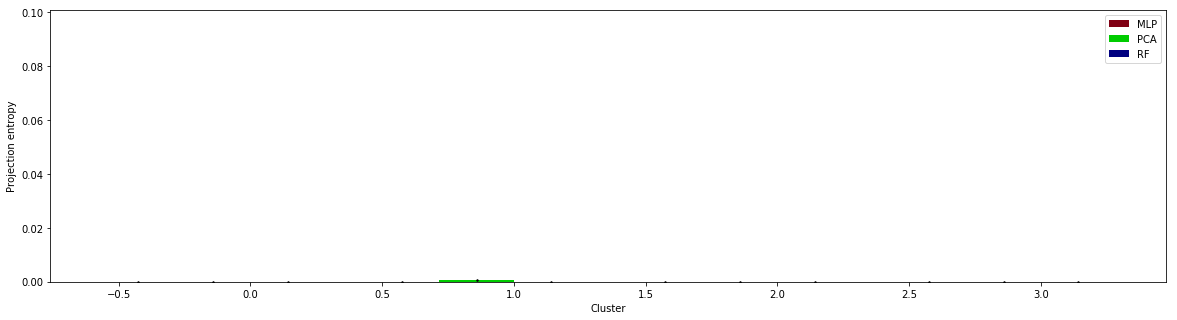

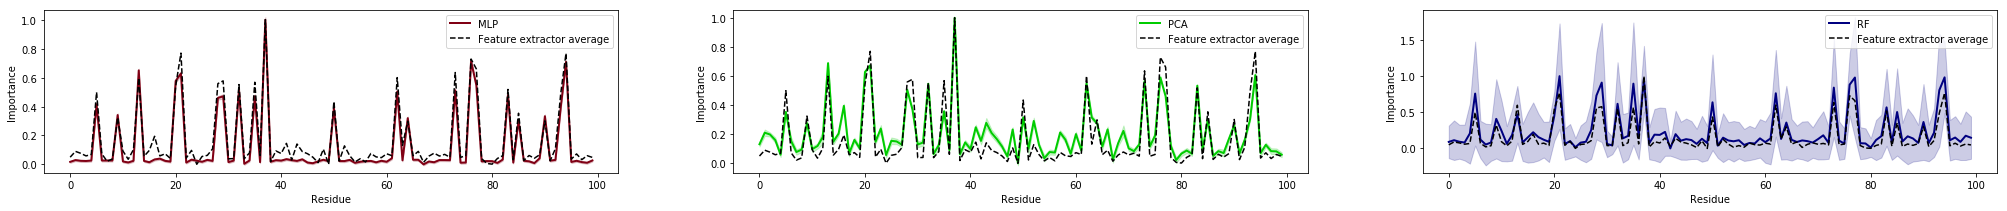

2019-02-12 11:00:21 dataGenNb-INFO: Done


In [7]:
visualization.visualize(postprocessors)
logger.info("Done")